In [1]:
from init_nb import init_notebook
config = init_notebook()
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.utils.configuration import get_config
from bold_dementia.utils.saving import save_run
from bold_dementia.stats.univariate import make_fc_data, run_test, export_results, merge_configs
from bold_dementia.connectivity import reshape_pvalues, plot_matrix, Atlas, pivot_resdf, edges_to_matrix

ALPHA = config["alpha"]

In [2]:
ATLAS = "msdl"
atlas = Atlas.from_name(ATLAS)

In [3]:
expname = f"atlas-{ATLAS}_merged_ols-cenanom"
respath = Path(config["output_dir"]) / "statresults" / expname

In [4]:
null = pd.read_csv(respath / "null_distribution.csv", index_col=0)
resdf = pd.read_csv(respath / "resdf.csv", index_col=0)

In [5]:
permutation_scores = null.select_dtypes(float).values # Last col is edge name
score = resdf["beta_AD"].values
score = np.stack([score for _ in range(permutation_scores.shape[1])], axis=1) # Make scores broadcastable on permutation_scores

In [6]:
np.abs(permutation_scores) >= np.abs(score)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

In [7]:
N = permutation_scores.shape[1]
pvalues = (1 + np.sum(np.abs(permutation_scores) >= np.abs(score), axis=1)) / (N + 1) # observed as permutation?

In [8]:
from statsmodels.stats.multitest import fdrcorrection
print(f"Correcting FDR with {len(pvalues)} comparisons")
_, pvalues_corr = fdrcorrection(pvalues)

Correcting FDR with 741 comparisons


In [9]:
np.sum(pvalues_corr < config["alpha"])

65

In [10]:
# TODO Show matrix or export
from bold_dementia.connectivity import edges_to_matrix
resdf["pvalues_perm_fdr"] = pvalues_corr
resdf["thresholded_beta"] = np.where(pvalues_corr < 0.05, resdf.beta_AD, 0)
pv = edges_to_matrix(resdf)

In [11]:
from bold_dementia.visualisation.chord_plot import make_links, create_chord
matrix_df = pv.thresholded_beta
links = make_links(matrix_df, zoom=10)

Basal R Aud 0.0687786619919284 0.687786619919284
Broca L TPJ -0.0730456784397511 0.7304567843975109
Broca R TPJ -0.0573487654540949 0.573487654540949
Cereb D ACC -0.0618230730740971 0.618230730740971
Cereb L LOC 0.0673561939589331 0.673561939589331
Cereb L Par -0.0596736112469461 0.596736112469461
Cereb Occ post 0.0757430690788761 0.7574306907887609
Cereb R LOC 0.1035877722221407 1.035877722221407
Cereb Vis 0.1135855833396129 1.135855833396129
Cing L IPS -0.0520781071063264 0.520781071063264
Cing R IPS -0.0618832429921462 0.6188324299214619
D ACC Cereb -0.0618230730740971 0.618230730740971
D ACC Front DMN 0.0638307825945762 0.638307825945762
D ACC Motor 0.0734451480950738 0.734451480950738
D ACC R TPJ -0.0485283835758478 0.485283835758478
Dors PCC L Par 0.0705489629105693 0.7054896291056929
Dors PCC Vis -0.0548867243196318 0.548867243196318
Front DMN D ACC 0.0638307825945762 0.638307825945762
Front DMN R A Ins 0.0708905323289779 0.7089053232897791
Front DMN V ACC 0.0840279752733431 0.8

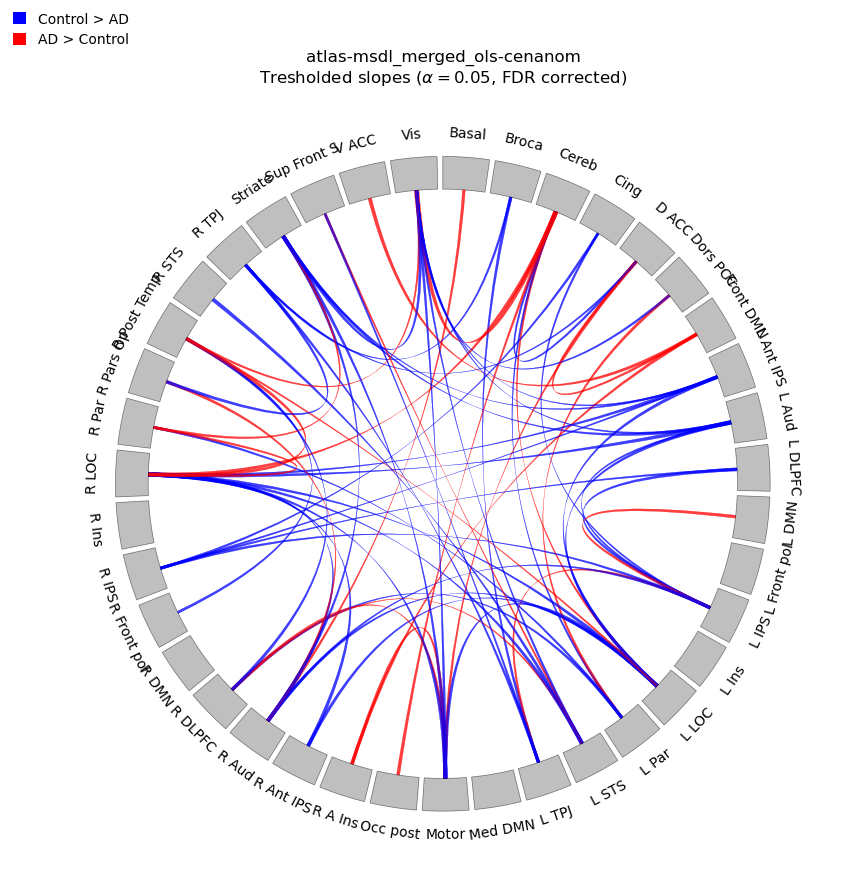

In [12]:
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', label='Control > AD')
red_patch = mpatches.Patch(color='red', label='AD > Control')

networks = matrix_df.columns.to_list()
fig = create_chord(networks, links)
fig.legend(handles=[blue_patch, red_patch])
fig.suptitle(
    f"{expname}\nTresholded slopes ($\\alpha = ${ALPHA}, FDR corrected)",
    y=1.01
)
plt.show()

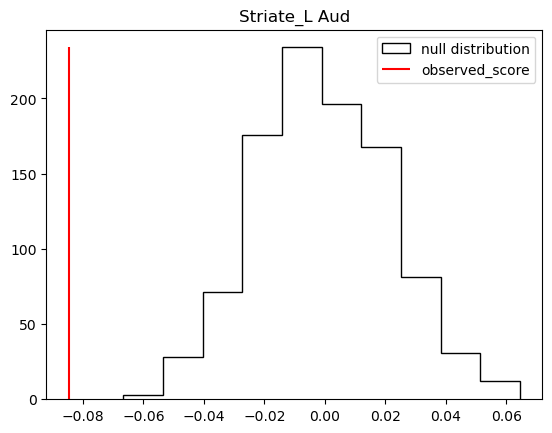

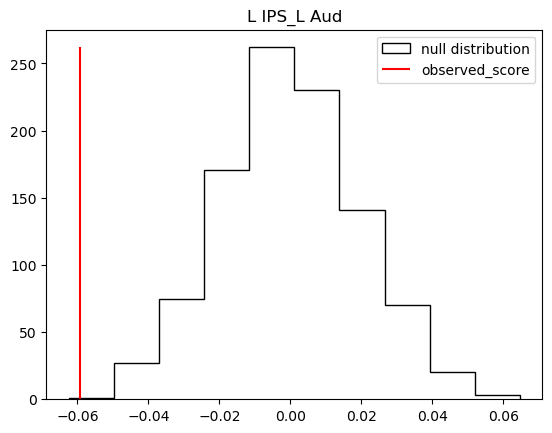

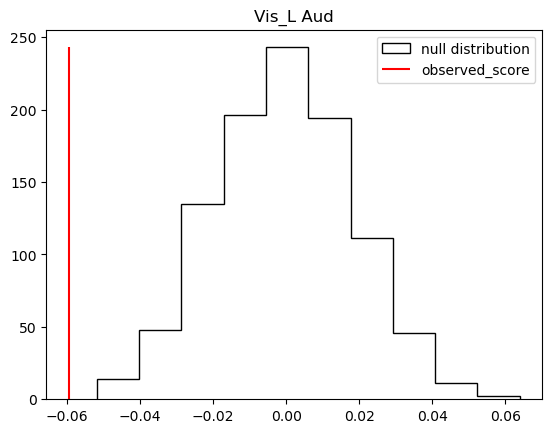

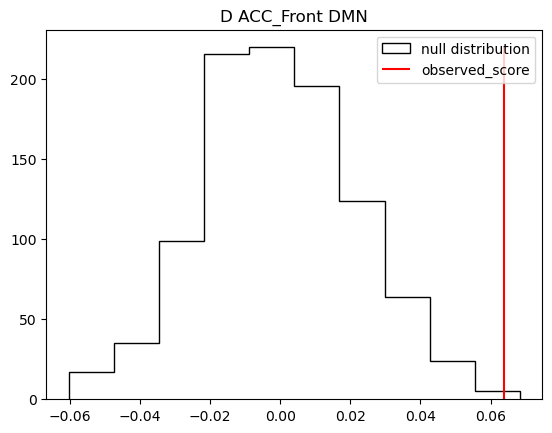

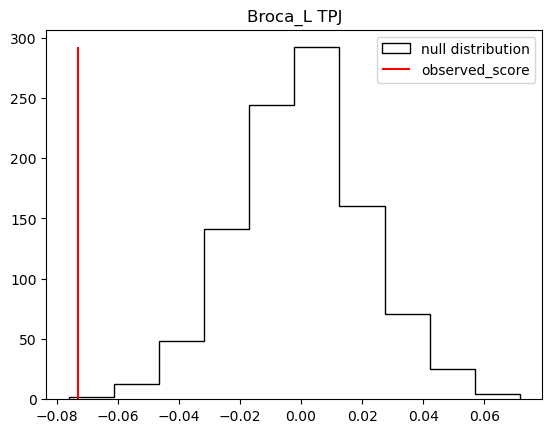

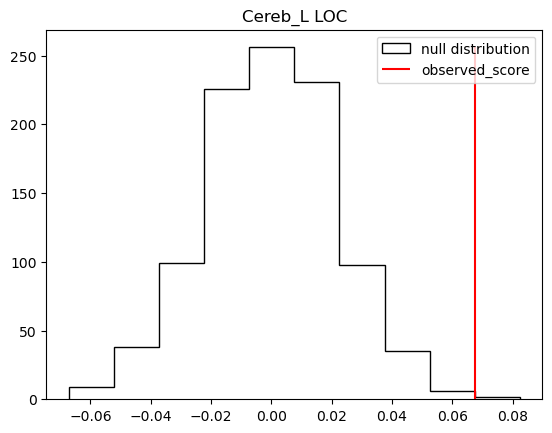

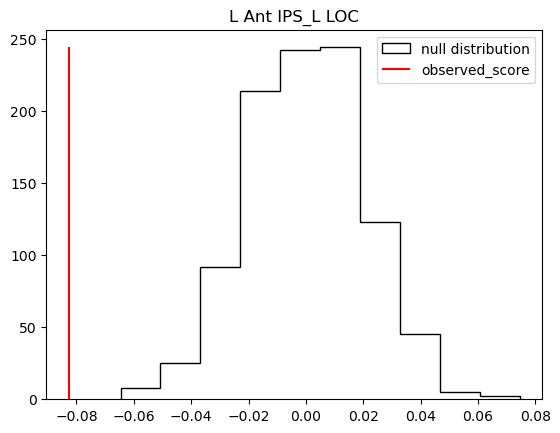

In [13]:

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

sig_idx = np.where(pvalues_corr <= ALPHA)[0]

for idx in sig_idx[::10]:
    reference = permutation_scores[idx, :]
    observed_score = resdf.loc[idx, "beta_AD"]
    values, _, _ = plt.hist(reference, histtype="step", color="black", label="null distribution")
    plt.vlines(observed_score, 0, np.max(values), color="red", label="observed_score")
    plt.title(resdf.loc[idx, "edges"])
    plt.legend()
    plt.show()